# 0.1.3 Specifying the Number of Lines

Michael pointed out that in the true task only has one lines on each axis, so this should be a controllable parameter.

### Jupyter Extensions

Load [watermark](https://github.com/rasbt/watermark) to see the state of the machine and environment that's running the notebook. To make sense of the options, take a look at the [usage](https://github.com/rasbt/watermark#usage) section of the readme.

In [1]:
# Load `watermark` extension
%load_ext watermark
# Display the status of the machine and packages. Add more as necessary.
%watermark -v -n -m -g -b -t -p numpy,matplotlib,seaborn

Wed Feb 27 2019 13:48:42 

CPython 3.6.8
IPython 7.2.0

numpy 1.15.4
matplotlib 3.0.2
seaborn 0.9.0

compiler   : GCC 7.3.0
system     : Linux
release    : 4.15.0-45-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit
Git hash   : 9827c2e568837bc33ed859d3e44d2eff755a6f1f
Git branch : master


Load [autoreload](https://ipython.org/ipython-doc/3/config/extensions/autoreload.html) which will always reload modules marked with `%aimport`.

This behavior can be inverted by running `autoreload 2` which will set everything to be auto-reloaded *except* for modules marked with `%aimport`.

In [2]:
# Load `autoreload` extension
%load_ext autoreload
# Set autoreload behavior
%autoreload 1

Load `matplotlib` in one of the more `jupyter`-friendly [rich-output modes](https://ipython.readthedocs.io/en/stable/interactive/plotting.html). Some options (that may or may not have worked) are `inline`, `notebook`, and `gtk`.

In [3]:
# Set the matplotlib mode
%matplotlib inline

### Imports

Static imports that shouldn't necessarily change throughout the notebook.

In [6]:
# Standard library imports
import logging
from pprint import pprint

# Third party
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Progress bar
from tqdm import tqdm

Local imports that may or may not be autoreloaded. This section contains things that will likely have to be re-imported multiple times, and have additions or subtractions made throughout the project.

In [273]:
# Task script
%aimport leabratf.tasks.combinatorics.combigen
import leabratf.tasks.combinatorics.combigen as cg
# Visualization for the task
%aimport leabratf.visualization.combigen_heatmap
import leabratf.visualization.combigen_heatmap as cghm
# Utility functions
%aimport leabratf.utils
from leabratf.utils import setup_logging, as_list

### Initial Setup

Set [seaborn defaults](https://seaborn.pydata.org/generated/seaborn.set.html) for matplotlib.

In [8]:
sns.set()

Set up the logger configuration to something more useful than baseline. Creates log files for the different log levels in the `logs` directory.

See `logging.yml` for the exact logging configuration.

In [9]:
# Run base logger setup
setup_logging()
# Define a logger object
logger = logging.getLogger("leabratf")

## Combigen with Random Numbers of Lines

As it stands, the number of lines in the resulting `y` is randomly determined. Below is what the labels, `y`, look like and the resulting inputs, `x`, would look like. 

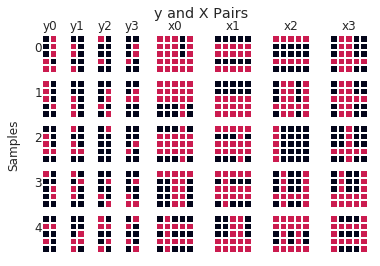

In [13]:
cghm.visualize_combigen(5)
plt.show()

As shown above, there are a random number of lines in the resulting `x` inputs which should be made controllable. And just to be clear on where the function stands, below is the implemenation as of now.

In [188]:
def generate_labels(n_samples=1, stack=4, size=5, dims=2):
    """Returns an array of labels to construct the data from."""
    # Generate baseline labels
    raw_labels = np.random.choice(2, (n_samples, stack, size, dims), replace=True)
    # Random selection of indices to zero out
    arg_zero = np.random.choice(size, (n_samples*dims*stack), replace=True)
    # Alternating indices to loop through the dims of the labels
    dim_indices = np.tile(range(dims), stack*n_samples)
    # Repeating indices to loop through the samples
    sample_indices = np.repeat(range(n_samples), dims*stack)
    # Stack indices
    stack_indices = np.repeat(np.tile(range(stack), n_samples), dims)
    # Zero out a random selection of indices
    raw_labels[sample_indices, stack_indices, arg_zero, dim_indices] = 0
    return raw_labels    

## Reworking the Implementation

So now let's rework the implementation to parametrize the desired number of lines for wach axis.

In [189]:
def generate_labels_n_lines(n_samples=1, stack=4, size=5, dims=2, n_lines=[1,1]):
    """Returns an array of labels to construct the data from."""
    # Generate a zero array to fill with 1s
    raw_labels = np.zeros((n_samples, stack, size, dims))

    # Create a list of length `dims` that contains arrays with the indices which to set
    # the value to 1. Each array is of shape `n_samples` by `stack` by `n_line[i]`
    # where `i` is the line index.
    arg_ones = [np.array([np.random.choice(range(size), line, replace=False)
                          for _ in range(n_samples*stack)])
                .reshape((n_samples,stack,line))
                for line in n_lines]

    # Use the index arrays created above to set the desired indices of the zero-array to
    # be 1 for each dim in dims.
    for dim, arg_one in enumerate(arg_ones):
        np.put_along_axis(raw_labels[:,:,:,dim], arg_one, values=1, axis=2)
    return raw_labels

And so lets visualize the changes that were made.

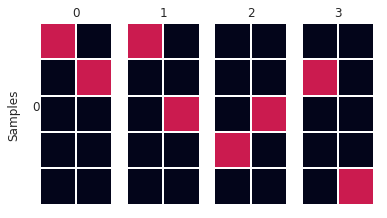

In [216]:
cghm.heatmap(generate_labels_n_lines(n_lines=[1,1]))
plt.show()

And now let's see for differnet numbers of lines.

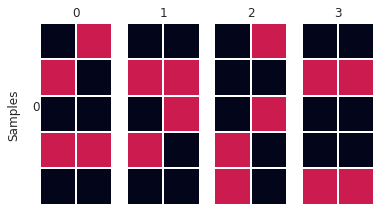

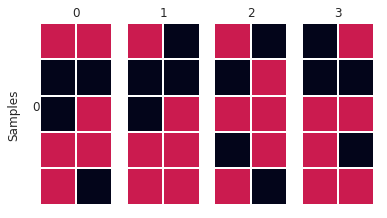

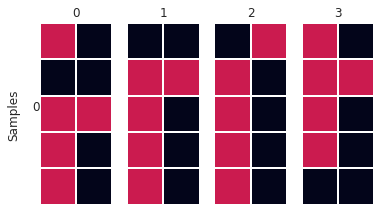

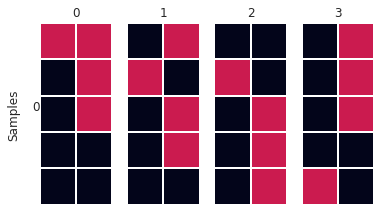

In [217]:
for n_lines in [(2,2), (3,3), (4,1), (1,3)]:
    cghm.heatmap(generate_labels_n_lines(n_lines=n_lines))
plt.show()

## Ensuring the Statistics are Correct

I was a little worried about the fequrency of getting certain indices over others, so let's just quickly try to ensure that the values are being set according to the expected statistics.

A quick way is to create labels with 1 `n_sample` and `stack`, but `N` numbers of `dims`, which we can then use to compute a sum accross the `dims` axis. What we expect to see is as `N` gets large, the sums all become increasingly similar.

In [259]:
dims = 1000

# Create an array containing all the sums of labels with `dims` dimensions. 
y_tests = np.array(
    [generate_labels_n_lines(n_samples=1, stack=1, dims=dims, n_lines=[1]*dims).sum(axis=-1)
     for _ in range(100)])

# Assert the standard deviation of the means of the sums is less than 1 percent of the total
# number of dimensions used.
assert 1 > y_tests.mean(axis=0).std() / dims
print(y_tests.mean(axis=0))

[[[200.71 199.54 200.76 198.79 200.2 ]]]


As expected they are all quite similar and do not vary much.

## Ensuring the Number of Lines is Always Correct

A more obvious test is to make sure that we are always getting the desired number of lines. So below loops through all combinations of lines and asserts that they sum to the correct number.

In [268]:
def test_number_of_lines(func=None, n_samples=100, size=5, dims=2, stack=4):
    func = func or generate_labels_n_lines
    for line_1 in range(size):
        for line_2 in range(size):
            labels = func(n_samples=n_samples, stack=stack, 
                          dims=dims, n_lines=[line_1, line_2])
            # Ensure the sums are exactly what we expect them to be at each combination
            assert np.array_equal(labels.sum(axis=(0,1,2)), 
                                  [line_1*stack*n_samples, line_2*stack*n_samples])
            
test_number_of_lines()
print('Passed!')

Passed!


## Handling Non-Conforming Arguments

The last modification that we should make is to ensure that the provided inputs are checked for some easy mistakes before trying to use them.

In [274]:
def generate_labels_n_lines_checked_inputs(n_samples=1, stack=4, size=5, dims=2, n_lines=[1,1]):
    """Returns an array of labels to construct the data from."""
    # Ensure this is a list
    n_lines = as_list(n_lines)
    # If one number is passed in for n_lines and there is more than 1 dim, then assume that
    # they should both be set to the value of n_lines.
    if len(n_lines) == 1 and dims != 1:
        n_lines *= dims
    # Ensure dims and `len(n_lines)` is the same
    if dims != len(n_lines):
        raise ValueError('Value for dims must match len(n_lines)')
    
    # Generate a zero array to fill with 1s
    raw_labels = np.zeros((n_samples, stack, size, dims))

    # Create a list of length `dims` that contains arrays with the indices which to set
    # the value to 1. Each array is of shape `n_samples` by `stack` by `n_line[i]`
    # where `i` is the line index.
    arg_ones = [np.array([np.random.choice(range(size), line, replace=False)
                          for _ in range(n_samples*stack)])
                .reshape((n_samples,stack,line))
                for line in n_lines]

    # Use the index arrays created above to set the desired indices of the zero-array to
    # be 1 for each dim in dims.
    for dim, arg_one in enumerate(arg_ones):
        np.put_along_axis(raw_labels[:,:,:,dim], arg_one, values=1, axis=2)
    return raw_labels

Now let's run a couple tests on this.

In [277]:
import pytest

# Test for integer n_line inputs
for line in range(5):
    generate_labels_n_lines_checked_inputs(n_samples=100, n_lines=line)
    # Ensure the sums are exactly what we expect them to be at each combination
    assert np.array_equal(labels.sum(axis=(0,1,2)), 
                          [line_1*stack*n_samples, line_2*stack*n_samples])
print('Passed 1!')

# Test that it raises an input error on invalid inputs
for i in range(3,10):
    with pytest.raises(ValueError):
        generate_labels_n_lines_checked_inputs(n_lines=[1]*i)
print('Passed 2!')

Passed 1!
Passed 2!
